<h1>
Final Project Group 31
<h/1>

<h3>
Reading the data
<h/3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (lognorm, expon, gamma, weibull_min, kstest, probplot)
from typing import List
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import (make_scorer, confusion_matrix)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('loan_sanction.csv')

C:\Users\joerg\AppData\Local\Temp\ipykernel_15184\3079389942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


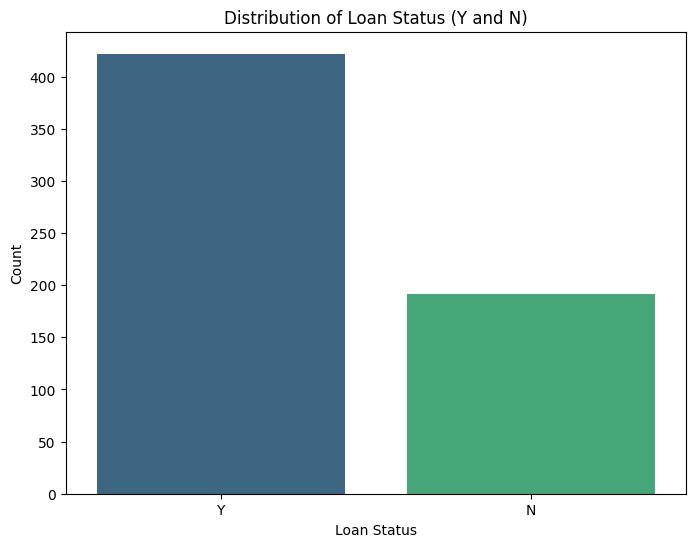

In [3]:
class_counts = df['Loan_Status'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add titles and labels
plt.title("Distribution of Loan Status (Y and N)")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

<h3>
Cleaning the Data
<h/3>

<h4>
Removing NaN values
<h/4>

In [4]:
print(f"Dimensions of the data: {df.shape}")
total_nan = df.isnull().sum().sum()
total_nan_col = df.isnull().sum()
print(f"Number of NaN: {total_nan}", f"\nNumber of NaN per column: \n{total_nan_col}")

Dimensions of the data: (614, 13)
Number of NaN: 149 
Number of NaN per column: 
Loan_ID                0
Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount           22
Loan_Amount_Term      14
Credit_History        50
Property_Area          0
Loan_Status            0
dtype: int64


In [5]:
def plot_nan_distributions(df: pd.DataFrame) -> None:
    """
    Plots the distribution of NaN values in the columns of the dataframe.
    """

    colums_with_nan = df.columns[df.isnull().any()].tolist()

    for col in colums_with_nan:
        plt.figure(figsize=(8, 4))
        df[col].value_counts(dropna=False).plot(kind='bar')
        plt.title(f"Distribution of '{col}' (including NaN values)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


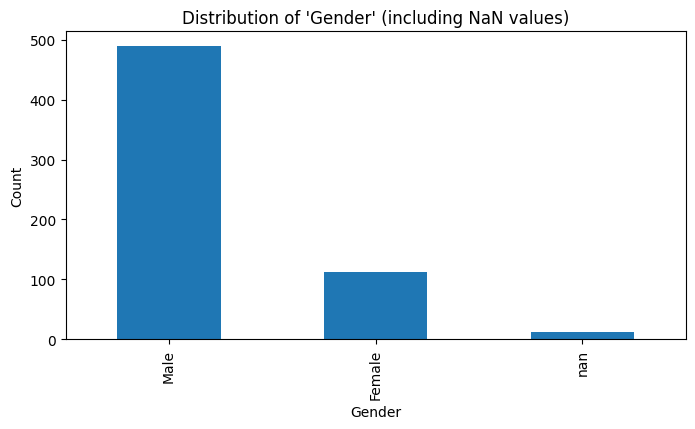

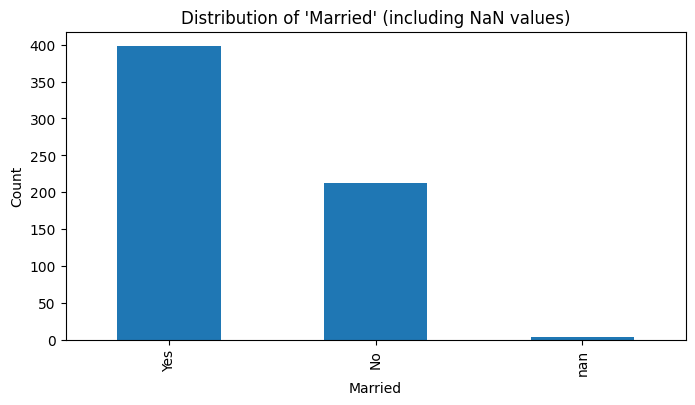

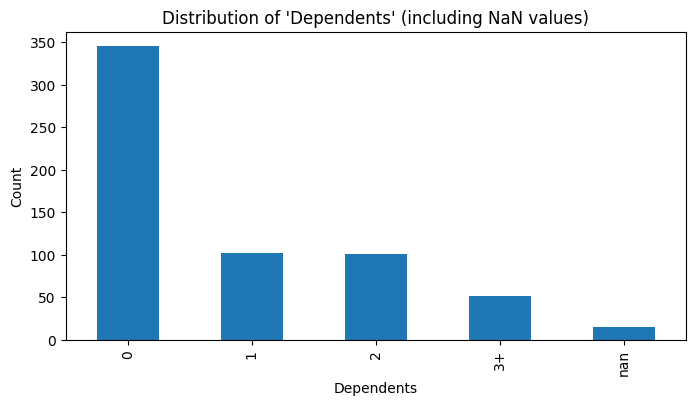

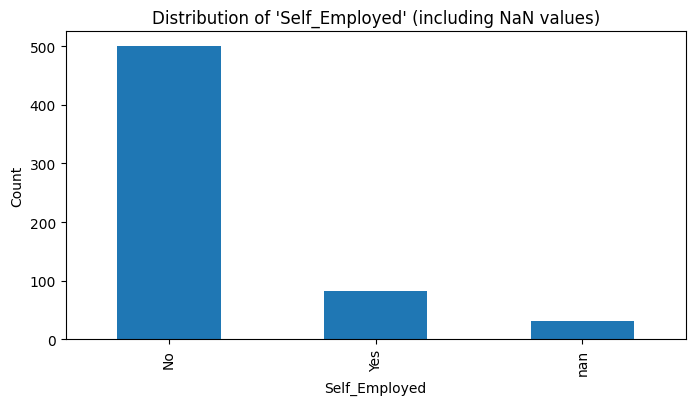

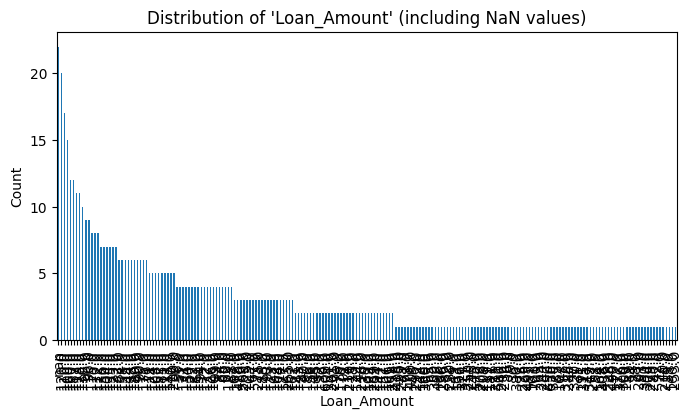

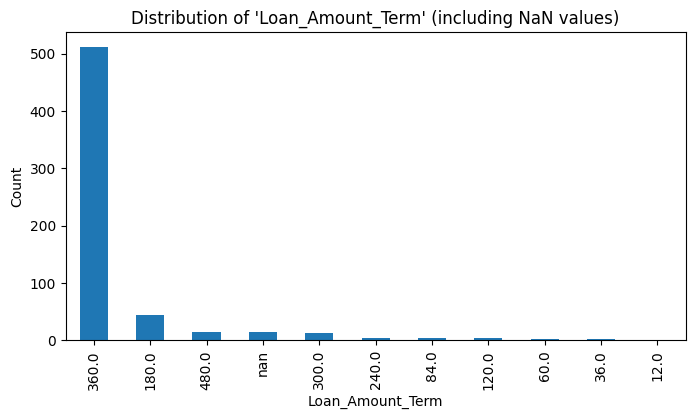

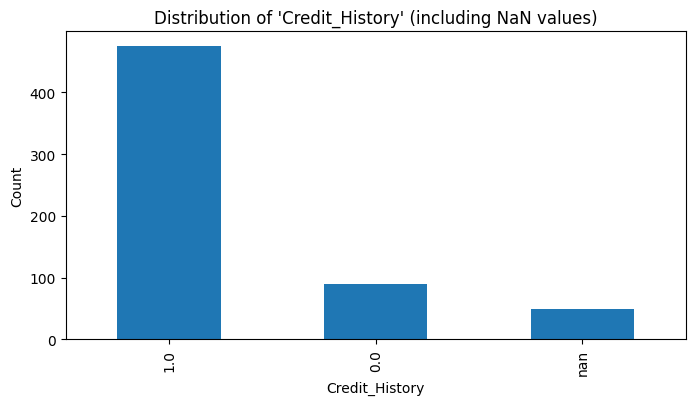

In [6]:
plot_nan_distributions(df)

In [7]:
def clean_data(df: pd.DataFrame, mode: List[str]) -> pd.DataFrame:
    """ 
    Clean the data by filling NaN values with the mean for 'Loan_Amount', 0 to the credit history,  and the mode for the columns in the 'mode' list.
    """

    cleaned_df = df.copy()
    cleaned_df['Credit_History'] = cleaned_df['Credit_History'].fillna(0)
    cleaned_df['Loan_Amount'] = cleaned_df['Loan_Amount'].fillna(cleaned_df['Loan_Amount'].mean())

    for col in mode:
        cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])

    return cleaned_df

In [8]:
#this was implement for the mode, however this ended up performing worse than the just dropping all NAN rows
# colums_2_clean = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']
# df = clean_data(df, colums_2_clean)

df = df.dropna()


total_nan = df.isnull().sum().sum()
print(f"Number of NaN: {total_nan}")

Number of NaN: 0


<h3>
Looking if loan amount is descrete or continous and if so perhaps add an ordinal or catagorical approach
<h/3>

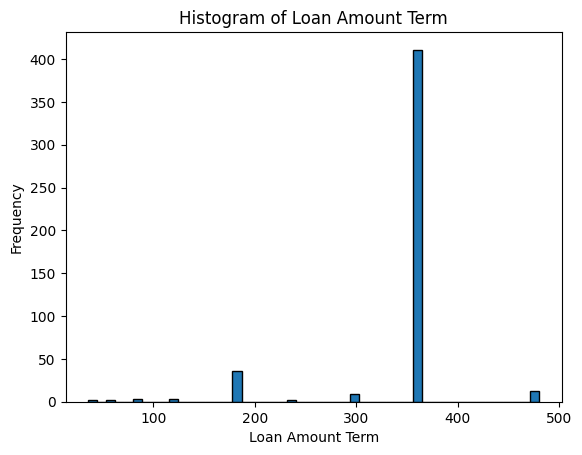

Loan_Amount_Term
360.0    411
180.0     36
480.0     12
300.0      9
120.0      3
84.0       3
60.0       2
240.0      2
36.0       2
Name: count, dtype: int64


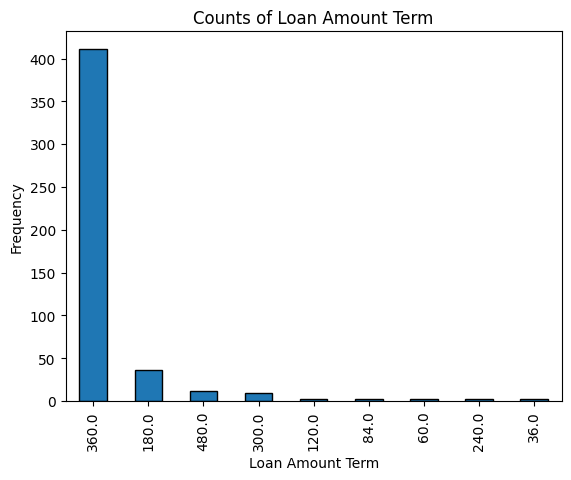

In [9]:
# Plot a histogram with a large number of bins to visualize the distribution
plt.hist(df['Loan_Amount_Term'], bins=50, edgecolor='black')
plt.title('Histogram of Loan Amount Term')
plt.xlabel('Loan Amount Term')
plt.ylabel('Frequency')
plt.show()

# Count the occurrences of each unique value in Loan_Amount_Term
loan_term_counts = df['Loan_Amount_Term'].value_counts()

# Print the counts
print(loan_term_counts)

# Optionally, visualize the counts as a bar plot
loan_term_counts.plot(kind='bar', edgecolor='black')
plt.title('Counts of Loan Amount Term')
plt.xlabel('Loan Amount Term')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Define a function to group Loan_Amount_Term into buckets
def group_loan_term(term):
    if term < 180:
        return 'Short'
    elif 180<=term < 360:
        return 'Medium'
    elif term == 360:
        return 'Standard'
    else:  # term > 360
        return 'Long'

# Apply the grouping function to the Loan_Amount_Term column
df['Loan_Amount_Term_Grouped'] = df['Loan_Amount_Term'].apply(group_loan_term)

# Display the grouped categories and their counts
print(df['Loan_Amount_Term_Grouped'].value_counts())

# Optional: One-hot encode the grouped categories for modeling
df = pd.get_dummies(df, columns=['Loan_Amount_Term_Grouped'], prefix='LoanTerm', drop_first=True)

df.head()


Loan_Amount_Term_Grouped
Standard    411
Medium       47
Long         12
Short        10
Name: count, dtype: int64


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,False,False,True
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,False,False,True
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,False,False,True
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,False,False,True
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,False,False,True


<h5>
An interesting case arises here because most co-applicants don't have an income. However, when a co-applicant first does have an income, I believe it is still normally attributed. Therefore, i am adding a column to the data indicating if a co-applicant is working or not, and then i will normalize that data
<h/5>

In [11]:

# Create a new column 'Coapplicant_Working'
df['Coapplicant_Working'] = np.where(df['Coapplicant_Income'] > 0, 1, 0)

df.head() 

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Coapplicant_Working
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,False,False,True,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,False,False,True,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,False,False,True,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,False,False,True,0
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,False,False,True,1


<h3>
Normalizing Data
<h/3>

<h5>
the "Loan_Amount" seems to be following a exponetial decreasing,  log normal or gamma distribution. Depending on which model fits better we should normalize the data
<h/5>

In [12]:

def best_fit_distribution(df: pd.DataFrame, column:str):
    """
    Finds the best-fitting distribution for a specified column in a cleaned DataFrame.
    
    Parameters:
    df (pd.DataFrame): Cleaned DataFrame containing the data.
    column (str): Name of the column to fit distributions to.

    Returns:
    dict: Dictionary containing the name, KS statistic, p-value, and parameters of the best-fitting distribution.
    """
    # Candidate distributions to test
    distributions = {
        'Log-normal': lognorm,
        'Exponential': expon,
        'Gamma': gamma,
        'Weibull': weibull_min
        
    }

    fit_results = {}

    # Loop over distributions to fit and test
    for name, distribution in distributions.items():
        params = distribution.fit(df[column])
        d_statistic, p_value = kstest(df[column], distribution.name, args=params)
        fit_results[name] = {
            'KS Statistic': d_statistic,
            'p-value': p_value,
            'Parameters': params
        }

    # Find the best distribution based on the highest p-value
    best_fit = max(fit_results.items(), key=lambda x: x[1]['p-value'])
    best_distribution = {
        'Best Distribution': best_fit[0],
        'KS Statistic': best_fit[1]['KS Statistic'],
        'p-value': best_fit[1]['p-value'],
        'Parameters': best_fit[1]['Parameters']
    }

    # Print the best-fitting distribution in a clear format
    print("\nBest Fitting Distribution:\n")
    print(f"{best_distribution['Best Distribution']}:")
    print(f"  KS Statistic: {best_distribution['KS Statistic']:.4f}")
    print(f"  p-value: {best_distribution['p-value']:.4f}")
    print(f"  Parameters: {best_distribution['Parameters']}\n")


In [13]:
best_fit_distribution(df, 'Loan_Amount')


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0727
  p-value: 0.0118
  Parameters: (0.4095879835419134, -25.435168143569296, 155.88239942964879)



In [14]:
best_fit_distribution(df, 'Applicant_Income')



Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0882
  p-value: 0.0011
  Parameters: (0.6085508325462675, -69.45757655262365, 4330.657404988655)



In [15]:
df_coapplicants = df[df['Coapplicant_Income'] > 0].copy()
best_fit_distribution(df_coapplicants , 'Coapplicant_Income')


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0984
  p-value: 0.0112
  Parameters: (0.5710928487636875, -293.9600697099792, 2612.595429550061)



<h5>
The original distributions of Loan_Amount, Applicant Income, and Co-applicant Income exhibit right-skewed (log-normal) distributions. By applying a logarithmic transformation to these variables, we successfully converted them into approximately normal distributions. This transformation is crucial for our analysis as many statistical methods assume normality. The more symmetric, bell-shaped distributions resulting from this transformation will help ensure more reliable results in our subsequent analyses
<h/5>

In [16]:
#Add a log-transformed version of Loan_Amount and Application Income to the DataFrame
df['Log_Loan_Amount_Log'] = np.log1p(df['Loan_Amount']) 
df['Log_Applicant_Income'] = np.log1p(df['Applicant_Income']) 
df['Log_Coapplicant_Income'] = np.log1p(df['Coapplicant_Income'])
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Coapplicant_Working,Log_Loan_Amount_Log,Log_Applicant_Income,Log_Coapplicant_Income
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,False,False,True,1,4.859812,8.430327,7.319202
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,False,False,True,0,4.204693,8.006701,0.000000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,False,False,True,1,4.795791,7.857094,7.765993
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,False,False,True,0,4.955827,8.699681,0.000000
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,False,False,True,1,5.590987,8.597482,8.342125


### Inspect the tranformation and validity

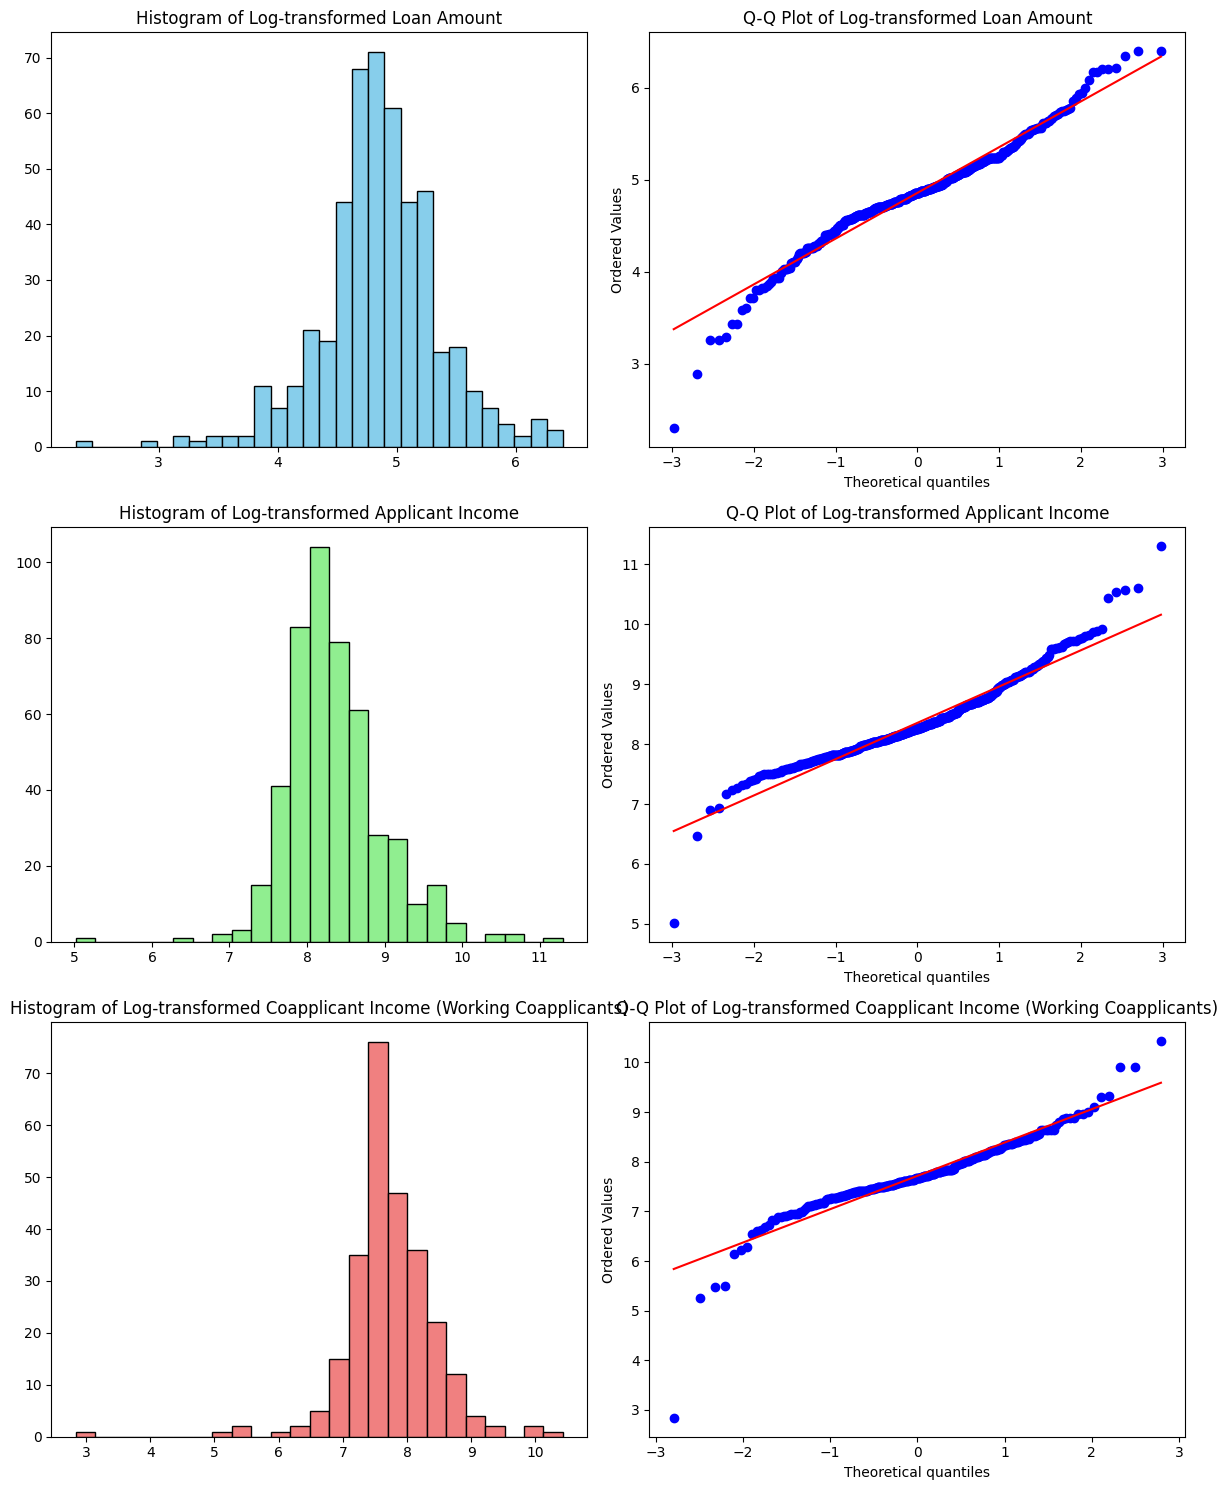

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Loan Amount Log-transformed
axs[0, 0].hist(df['Log_Loan_Amount_Log'], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title("Histogram of Log-transformed Loan Amount")

probplot(df['Log_Loan_Amount_Log'], dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Q-Q Plot of Log-transformed Loan Amount")

# Applicant Income Log-transformed
axs[1, 0].hist(df['Log_Applicant_Income'], bins=25, color='lightgreen', edgecolor='black')
axs[1, 0].set_title("Histogram of Log-transformed Applicant Income")

probplot(df['Log_Applicant_Income'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot of Log-transformed Applicant Income")

# Filter the DataFrame for working coapplicants"
df_working_coapplicants = df[df['Coapplicant_Working'] == 1] 

axs[2, 0].hist(df_working_coapplicants['Log_Coapplicant_Income'], bins=25, color='lightcoral', edgecolor='black')
axs[2, 0].set_title("Histogram of Log-transformed Coapplicant Income (Working Coapplicants)")

probplot(df_working_coapplicants['Log_Coapplicant_Income'], dist="norm", plot=axs[2, 1])
axs[2, 1].set_title("Q-Q Plot of Log-transformed Coapplicant Income (Working Coapplicants)")


plt.tight_layout()
plt.show()

<h3>
Explore the covariance and correlation matrix
<h/3>

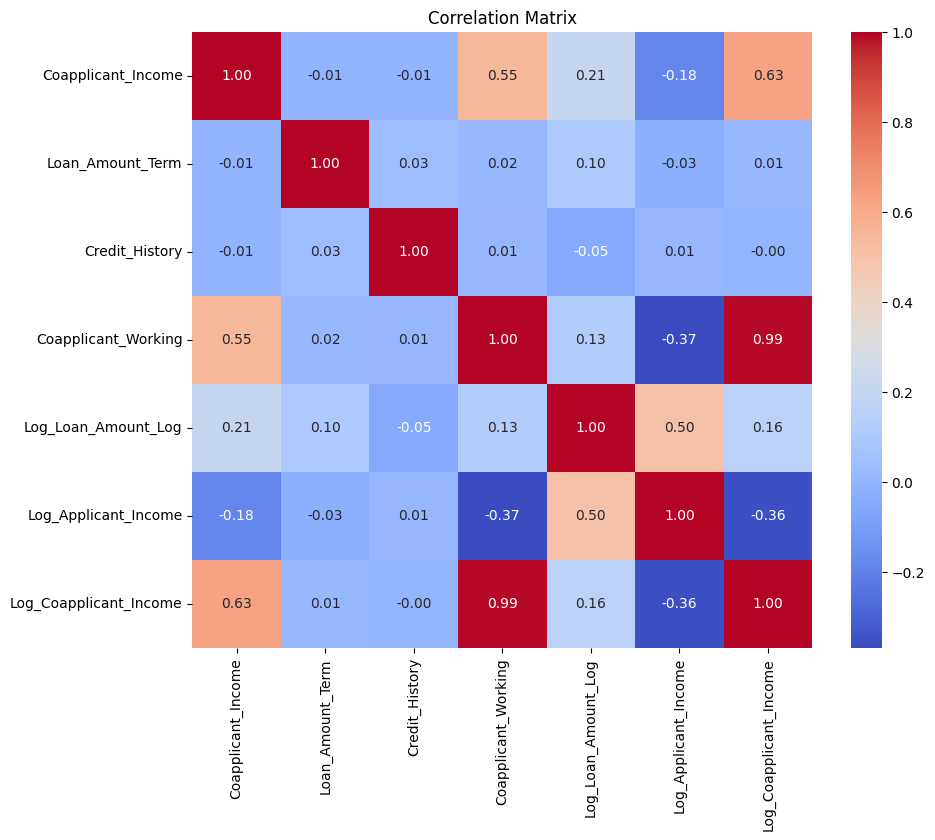

In [18]:
# Calculate the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(columns=['Loan_Amount', 'Applicant_Income'])

correlation_matrix = numeric_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


<h3>
One-hot encoding of categroical features
<h/3>

In [19]:
binary_vars = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Loan_Status', 'Coapplicant_Working']
df_encoded = pd.get_dummies(df, columns=binary_vars, drop_first=True)


multi_class_vars = ['Property_Area', 'Dependents']
df_encoded = pd.get_dummies(df_encoded, columns=multi_class_vars, drop_first=True)

df_encoded.head()


,Loan_ID,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Log_Loan_Amount_Log,Log_Applicant_Income,...,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Loan_Status_Y,Coapplicant_Working_1,Property_Area_Semiurban,Property_Area_Urban,Dependents_1,Dependents_2,Dependents_3+
1,LP001003,4583,1508.0,128.0,360.0,False,False,True,4.859812,8.430327,...,False,False,True,False,True,False,False,True,False,False
2,LP001005,3000,0.0,66.0,360.0,False,False,True,4.204693,8.006701,...,False,True,True,True,False,False,True,False,False,False
3,LP001006,2583,2358.0,120.0,360.0,False,False,True,4.795791,7.857094,...,True,False,True,True,True,False,True,False,False,False
4,LP001008,6000,0.0,141.0,360.0,False,False,True,4.955827,8.699681,...,False,False,True,True,False,False,True,False,False,False
5,LP001011,5417,4196.0,267.0,360.0,False,False,True,5.590987,8.597482,...,False,True,True,True,True,False,True,False,True,False


<h3>
KNN
<h/3>

In [20]:
def specificity_score(y_true: list, y_pred: list) -> float:
    """Calculate specificity (true negative rate)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true: list, y_pred: list) -> float:
    """Calculate negative predictive value."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)



def find_best_knn_balanced(df_encoded: pd.DataFrame, max_k: int = 50) -> KNeighborsClassifier:
    """Find the best KNN model based on balanced accuracy.
    
    Returns:
    KNeighborsClassifier - Best KNN model based on GridSearchCV.
    """
    X = df_encoded.drop(['Loan_ID', 'Loan_Status_Y'], axis=1)
    y = df_encoded['Loan_Status_Y']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    param_grid = {'n_neighbors': range(1, max_k)}
    knn = KNeighborsClassifier(weights='distance')  # Using distance-based weights
    
    grid_search = GridSearchCV(knn, param_grid, cv=5, 
                               scoring='balanced_accuracy', 
                               n_jobs=-1)
    grid_search.fit(X_scaled, y)
    
    # Plot scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k), grid_search.cv_results_['mean_test_score'])
    plt.xlabel('k neighbors')
    plt.ylabel('Balanced Accuracy')
    plt.grid(True)
    plt.show()
    
    print(f"Best k: {grid_search.best_params_['n_neighbors']}")
    return grid_search.best_estimator_

def implement_knn(df_encoded: pd.DataFrame, n_neighbors: int) -> dict:
    """Train and evaluate a KNN model using cross-validation.
    
    Parameters:
    n_neighbors: int - Number of neighbors for the KNN model.

    Returns:
    dict - Dictionary with cross-validated metrics.
    """
    X = df_encoded.drop(['Loan_ID', 'Loan_Status_Y'], axis=1)
    y = df_encoded['Loan_Status_Y']
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define KNN model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    
    # Define scoring metrics
    scoring = {
        'balanced_accuracy': 'balanced_accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'specificity': make_scorer(specificity_score),
        'npv': make_scorer(npv_score)
    }
    
    # Perform cross-validation
    cv_results = cross_validate(knn, X_scaled, y, cv=5, scoring=scoring)
    
    return {
        'cv_balanced_accuracy': cv_results['test_balanced_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_balanced_accuracy'].std(),
        'cv_precision': cv_results['test_precision'].mean(),
        'cv_recall': cv_results['test_recall'].mean(),
        'cv_f1': cv_results['test_f1'].mean(),
        'cv_specificity': cv_results['test_specificity'].mean(),
        'cv_npv': cv_results['test_npv'].mean()
    }


<h3>For our analysis we only want to inlude the colums of which he have scaled or transformed<h/3>

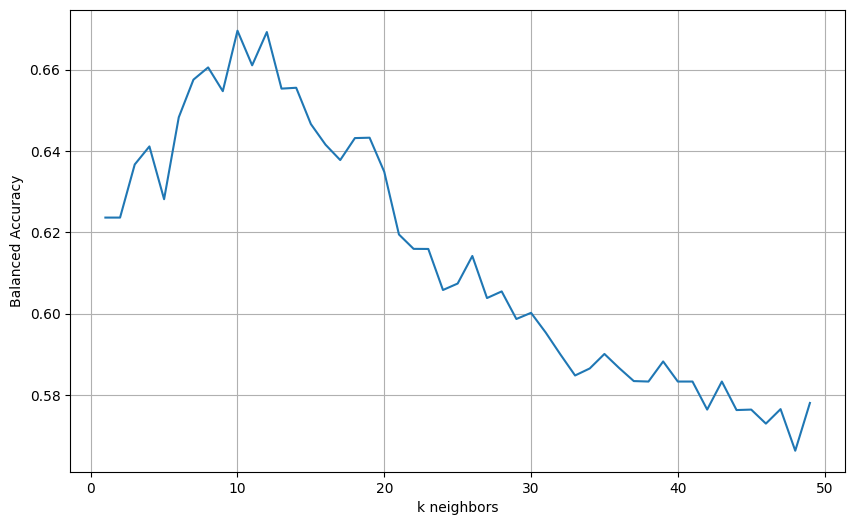

Best k: 10
Recommended k to avoid overfitting: KNeighborsClassifier(n_neighbors=10, weights='distance')


In [21]:
selected_features = [
    'LoanTerm_Medium', 'LoanTerm_Short', 'LoanTerm_Standard', 'Log_Loan_Amount_Log',
    'Log_Applicant_Income', 'Log_Coapplicant_Income', 'Gender_Male', 'Married_Yes',
    'Education_Not Graduate', 'Self_Employed_Yes', 'Credit_History_1.0',
    'Coapplicant_Working_1', 'Property_Area_Semiurban', 'Property_Area_Urban',
    'Dependents_1', 'Dependents_2', 'Dependents_3+'
]

df_selected = df_encoded[['Loan_ID', 'Loan_Status_Y'] + selected_features]

optimal_k = find_best_knn_balanced(df_selected)
print(f"Recommended k to avoid overfitting: {optimal_k}")

In [22]:
implement_knn(df_selected, n_neighbors=10)

C:\Users\joerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\joerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'cv_balanced_accuracy': 0.6695609725666338,
 'cv_accuracy_std': 0.04544384360840779,
 'cv_precision': 0.776238263532648,
 'cv_recall': 0.9669380370872908,
 'cv_f1': 0.860851542952912,
 'cv_specificity': 0.37218390804597695,
 'cv_npv': 0.8290476190476191}

<h3>
Logsistic Regression
<h/3>

In [23]:
def logistic_regression(df_encoded: pd.DataFrame, penalty: str = None, C: float = 1.0, solver: str = 'lbfgs') -> dict:
    """Train and evaluate a logistic regression model using cross-validation.
    
    Parameters:
    df_encoded: pd.DataFrame - Encoded dataset with features and target.
    penalty: str - Regularization type ('l1', 'l2', 'elasticnet', or None for no regularization).
    C: float - Inverse of regularization strength (higher values mean less regularization).
    solver: str - Algorithm to use for optimization.
    
    """
    X = df_encoded.drop(['Loan_ID', 'Loan_Status_Y'], axis=1)
    y = df_encoded['Loan_Status_Y']
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize Logistic Regression
    logistic_model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000)
    
    # Define scoring metrics
    scoring = {
        'balanced_accuracy': 'balanced_accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'specificity': specificity_scorer,
        'npv': npv_scorer
    }
    
    # Perform cross-validation
    cv_results = cross_validate(logistic_model, X_scaled, y, cv=5, scoring=scoring)
    
    return {
        'cv_balanced_accuracy': cv_results['test_balanced_accuracy'].mean(),
        'cv_balanced_accuracy_std': cv_results['test_balanced_accuracy'].std(),
        'cv_precision': cv_results['test_precision'].mean(),
        'cv_recall': cv_results['test_recall'].mean(),
        'cv_f1': cv_results['test_f1'].mean(),
        'cv_specificity': cv_results['test_specificity'].mean(),
        'cv_npv': cv_results['test_npv'].mean()
    }


specificity_scorer = make_scorer(specificity_score)
npv_scorer = make_scorer(npv_score)

In [24]:
logistic_regression(df_selected, penalty=None)


{'cv_balanced_accuracy': 0.7083313838331852,
 'cv_balanced_accuracy_std': 0.055790321711058195,
 'cv_precision': 0.801414762607544,
 'cv_recall': 0.9488466757123474,
 'cv_f1': 0.8681376387530519,
 'cv_specificity': 0.46781609195402296,
 'cv_npv': 0.8047699849170437}

In [25]:
# With Ridge regularization

logistic_regression(df_encoded, penalty='l2', C=1.0, solver='lbfgs')



{'cv_balanced_accuracy': 0.7141062711520766,
 'cv_balanced_accuracy_std': 0.0516525130625951,
 'cv_precision': 0.8068845805331117,
 'cv_recall': 0.9399366802351878,
 'cv_f1': 0.8670503341736218,
 'cv_specificity': 0.4882758620689655,
 'cv_npv': 0.7910714285714285}

In [26]:
# With Lasso regularization
logistic_regression(df_encoded, penalty='l1', C=1, solver='liblinear')

{'cv_balanced_accuracy': 0.7170913457789422,
 'cv_balanced_accuracy_std': 0.05722858279443191,
 'cv_precision': 0.8075568494406747,
 'cv_recall': 0.945906829488919,
 'cv_f1': 0.8702944542060631,
 'cv_specificity': 0.4882758620689655,
 'cv_npv': 0.8026098901098901}

<h3>
Random Forest
<h/3>

In [27]:
def evaluate_model(model: object, X: pd.DataFrame, y: pd.Series) -> dict:
    """Evaluate a model using cross-validation with multiple metrics.
    
    Parameters:
    model: object - dont want to calculate all tehse metric for all tress, only top performer.
    X: pd.DataFrame - Feature matrix.
    y: pd.Series - Target vector.

    Returns:
    dict - Dictionary with cross-validated metrics.
    """
    scoring = {
        'balanced_accuracy': 'balanced_accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'specificity': make_scorer(specificity_score),
        'npv': make_scorer(npv_score)
    }
    
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring)
    
    return {
        'cv_balanced_accuracy': cv_results['test_balanced_accuracy'].mean(),
        'cv_balanced_accuracy_std': cv_results['test_balanced_accuracy'].std(),
        'cv_precision': cv_results['test_precision'].mean(),
        'cv_recall': cv_results['test_recall'].mean(),
        'cv_f1': cv_results['test_f1'].mean(),
        'cv_specificity': cv_results['test_specificity'].mean(),
        'cv_npv': cv_results['test_npv'].mean()
    }

def train_random_forest(df_encoded: pd.DataFrame) -> None:
    """
    Train a Random Forest model with hyperparameter tuning and evaluate it.
    """
    # Separate features and target
    X = df_encoded.drop(['Loan_ID', 'Loan_Status_Y'], axis=1)
    y = df_encoded['Loan_Status_Y']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Apply SMOTE for class balance
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
    
    # Define parameter grid
    param_grid = {
        'max_depth': [5, 7, 9, 12],
        'n_estimators': [100, 200, 300],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['entropy', 'gini']
    }
    
    # Initialize and train Random Forest with GridSearch
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_resampled, y_resampled)
    
    # Get comprehensive metrics for best model
    best_model = grid_search.best_estimator_
    metrics = evaluate_model(best_model, X_resampled, y_resampled)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importance)), feature_importance['importance'])
    plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45, ha='right')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nRandom Forest Results:")
    print("Best parameters:", grid_search.best_params_)
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    


Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\joerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


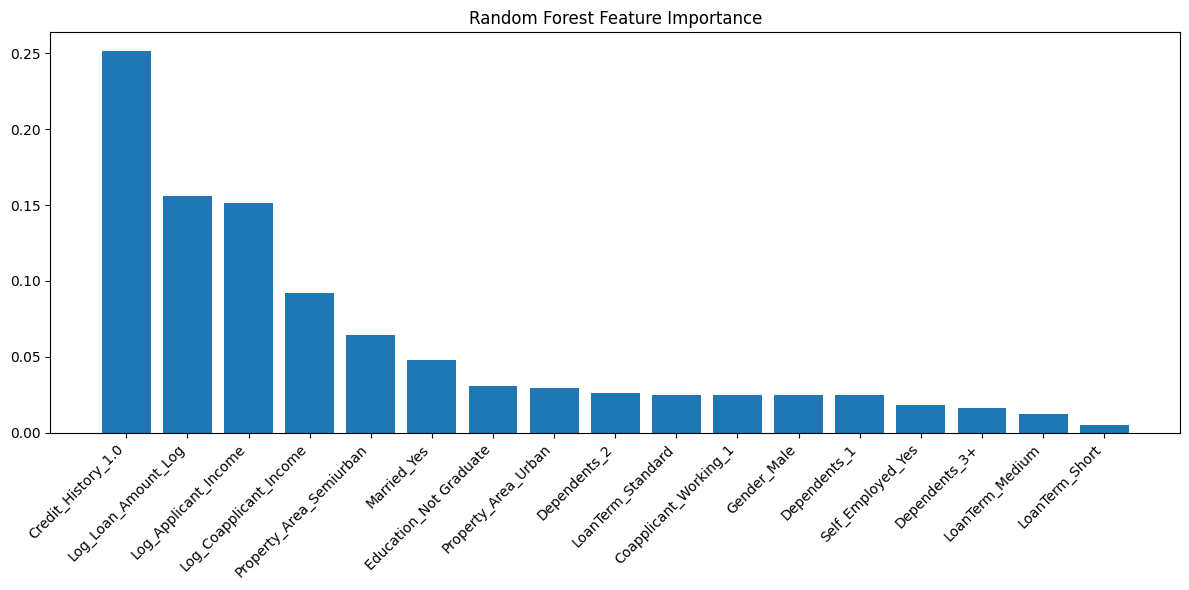


Random Forest Results:
Best parameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Model Performance Metrics:
cv_balanced_accuracy: 0.8334
cv_balanced_accuracy_std: 0.0643
cv_precision: 0.8150
cv_recall: 0.8917
cv_f1: 0.8458
cv_specificity: 0.7750
cv_npv: 0.8789

Top 10 Most Important Features:
                    feature  importance
10       Credit_History_1.0    0.251286
3       Log_Loan_Amount_Log    0.156058
4      Log_Applicant_Income    0.151525
5    Log_Coapplicant_Income    0.092128
12  Property_Area_Semiurban    0.064236
7               Married_Yes    0.047738
8    Education_Not Graduate    0.030694
13      Property_Area_Urban    0.029582
15             Dependents_2    0.025941
2         LoanTerm_Standard    0.024947


In [28]:

train_random_forest(df_selected)